# LSTM Time Series Explorations with Keras

A short exploration into applying LSTM techniques using the Keras library. Code and content is based on several cool blog posts and papers; see references section for more info.

**FIXMEs**: 
* This is work in progress; not all sections have been completed, or cleaned.
* Add more explanations and interpretations.
* Compare and contrast different parametrizations or architectures.
* Consolidate helper functions, simplify.

## Example 1: Airline Passenger Data
 
In this example we wish to make forcasts on a univariate timeseries of international airline passengers.
 
For this purpose, we consider a simple regression-type problem. 

Let ${X_t}$ denote the number of airline passengers in month $t$. Then: 
 
$$
X_t = f(X_{t-1}, \Theta)
$$
 
which we aim to solve using the an LSTM neural network. 

Here $X_t$ is the number of passengers at time step $t$, $X_{t-1}$ denotes  number of passengers at the previous time step, and $\Theta$ refers to all the other model parameters, including LSTM hyperparameters.

*Note*: For better readability, in the code for this as well as the next example, the predicted new value at time step $t$ is written as `Y`. 

### Loading and plotting the data

In [9]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Original data set retrieved from here:
# https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

# Run in Kaggle:
#path = "../input/international-airline-passengers.csv"

# Run locally:
path = "/data/international-airline-passengers.csv"

data = pd.read_csv(path, 
                      usecols = [1], 
                      engine = "python", 
                      skipfooter = 3)


In [10]:
data.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


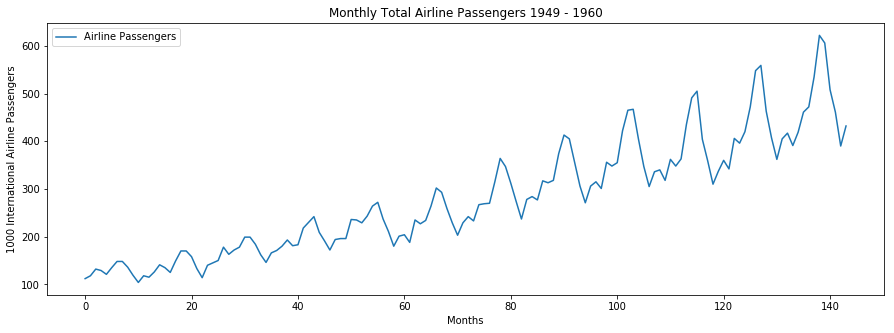

In [11]:
# Create a time series plot.
plt.figure(figsize = (15, 5))
plt.plot(data, label = "Airline Passengers")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

### Building the LSTM model


In [12]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

#### Data preparation

In [13]:
# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[ 0.01544401],
       [ 0.02702703],
       [ 0.05405405],
       [ 0.04826255],
       [ 0.03281853]], dtype=float32)

#### Split into test / training data

In [14]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))


Number of entries (training set, test set): (86, 58)


#### Get data into shape to use in Keras

In [15]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [16]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(84, 1)
New training data shape:
(84, 1, 1)


#### Build simple LSTM model on training data

The LSTM architecture here consists of:

* One input layer.
* One LSTM layer of 4 blocks.
* One `Dense` layer to produce a single output.
* Use MSE as loss function.

In [17]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/100
 - 0s - loss: 0.0236
Epoch 2/100
 - 0s - loss: 0.0111
Epoch 3/100
 - 0s - loss: 0.0081
Epoch 4/100
 - 0s - loss: 0.0074
Epoch 5/100
 - 0s - loss: 0.0069
Epoch 6/100
 - 0s - loss: 0.0064
Epoch 7/100
 - 0s - loss: 0.0060
Epoch 8/100
 - 0s - loss: 0.0054
Epoch 9/100
 - 0s - loss: 0.0049
Epoch 10/100
 - 0s - loss: 0.0043
Epoch 11/100
 - 0s - loss: 0.0039
Epoch 12/100
 - 0s - loss: 0.0035
Epoch 13/100
 - 0s - loss: 0.0030
Epoch 14/100
 - 0s - loss: 0.0027
Epoch 15/100
 - 0s - loss: 0.0025
Epoch 16/100
 - 0s - loss: 0.0022
Epoch 17/100
 - 0s - loss: 0.0020
Epoch 18/100
 - 0s - loss: 0.0019
Epoch 19/100
 - 0s - loss: 0.0019
Epoch 20/100
 - 0s - loss: 0.0017
Epoch 21/100
 - 0s - loss: 0.0018
Epoch 22/100
 - 0s - loss: 0.0017
Epoch 23/100
 - 0s - loss: 0.0017
Epoch 24/100
 - 0s - loss: 0.0017
Epoch 25/100
 - 0s - loss: 0.0017
Epoch 26/100
 - 0s - loss: 0.0018
Epoch 27/100
 - 0s - loss: 0.0017
Epoch 28/100
 - 0s - loss: 0.0017
Epoch 29/100
 - 0s - loss: 0.0017
Epoch 30/100
 - 0s - lo

### Results
#### Predictions and model evaluation


In [18]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 20.97 RMSE
Test data score: 47.55 RMSE


#### Plotting original data, predictions, and forecast

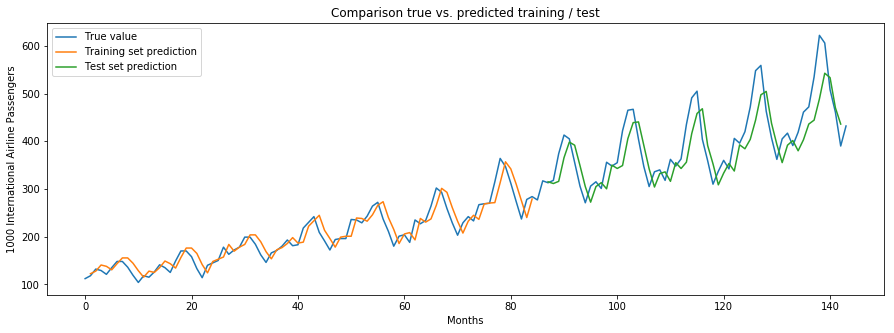

In [19]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()


### Next steps and things to explore

* Work with de-trended, stationary time series.
* Different window size (multiple regression). See Example 2.
* LSTM architecture, i.e. more layers, neurons etc.
* Impact of various hyperparameters in LSTM network on prediction accuracy.

## Example 2: Sinus wave data

For the second example, we'll generate synthetic data from a sinus curve, i.e.: $y = sin(x)$.

Unlike in the example above, now we'll build a *multiple regression* model where we treat a range of input values at previous time steps as inputs for predicting the output value at the next time step. 

The number of previous time steps is called the *window size*. In the below we'll be using a window size of $50$, i.e.: 

$$
X_t = f(X_{t-1}, X_{t-2}, ..., X_{t-50}, \Theta)
$$

### Generating and plotting the data

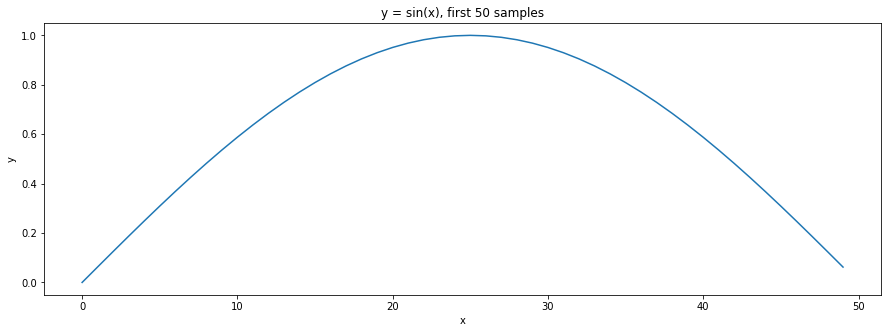

In [20]:
SAMPLES = 5000
PERIOD = 50
x = np.linspace(-PERIOD * np.pi, PERIOD * np.pi, SAMPLES)
series = pd.DataFrame(np.sin(x))

plt.figure(figsize = (15, 5))
plt.plot(series.values[:PERIOD])
plt.xlabel("x")
plt.ylabel("y")
plt.title("y = sin(x), first %d samples" % PERIOD)
plt.show()

### Building the LSTM model

#### Data preparation

First, we'll demonstrate the sliding window principle using a window size of 1; subsequently we'll move on to window size 50.

In [21]:
# Normalize data on the (-1, 1) interval.
scaler = MinMaxScaler(feature_range = (-1, 1))
scaled = scaler.fit_transform(series.values)

# Convert to data frame.
series = pd.DataFrame(scaled)

# Helper function to create a windowed data set.
# FIXME: Copying & overwriting is flawed!
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], 
                            axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

# FIXME: We'll use this only for demonstration purposes.
series_backup = series.copy()
t = create_window(series_backup, 1)
t.head()

,0,0
0,-9.821934e-16,0.062803
1,6.280307e-02,0.125358
2,1.253582e-01,0.187418
3,1.874184e-01,0.248739
4,2.487386e-01,0.309077


In [22]:
window_size = 50
series = create_window(series, window_size)
print("Shape of input data:")
print(series.shape)

Shape of input data:
(4950, 51)


#### Split into training / test set

In [23]:
# Using 80% of data for training, 20% for validation.
# FIXME: Need to align with example 1.
TRAIN_SIZE = 0.80

nrow = round(TRAIN_SIZE * series.shape[0])

train = series.iloc[:nrow, :]
test = series.iloc[nrow:, :]

# Shuffle training data.
train = shuffle(train)

train_X = train.iloc[:, :-1]
test_X = test.iloc[:, :-1]

train_Y = train.iloc[:, -1]
test_Y = test.iloc[:, -1]

print("Training set shape for X (inputs):")
print(train_X.shape)
print("Training set shape for Y (output):")
print(train_Y.shape)

Training set shape for X (inputs):
(3960, 50)
Training set shape for Y (output):
(3960,)


#### Get data into shape to use in Keras

In [24]:
train_X = np.reshape(train_X.values, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X.values, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(test_X.shape)

(3960, 50, 1)
(990, 50, 1)


#### Build LSTM model on training data

The model architecture used here is slightly more complex. Its elements are:

* LSTM input layer with 50 units.
* `Dropout` layer to prevent overfitting (see: http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf).
* A second LSTM layer with 256 units.
* A further `Dropout` layer.
* A `Dense` layer to produce a single output.
* Use MSE as loss function.

In [25]:
# Define the model.
model2 = Sequential()
model2.add(LSTM(input_shape = (window_size, 1), 
               units = window_size, 
               return_sequences = True))
model2.add(Dropout(0.5))
model2.add(LSTM(256))
model2.add(Dropout(0.5))
model2.add(Dense(1))
model2.add(Activation("linear"))
model2.compile(loss = "mse", 
              optimizer = "adam")
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


### Results
#### Predictions and model evaluation

In [26]:
# Fit the model.
model2.fit(train_X, 
          train_Y, 
          batch_size = 512,
          epochs = 3,
          validation_split = 0.1)

Train on 3564 samples, validate on 396 samples
Epoch 1/3
3564/3564 [==============================] - 13s 4ms/step - loss: 0.2690 - val_loss: 0.0768
Epoch 2/3
3564/3564 [==============================] - 10s 3ms/step - loss: 0.0542 - val_loss: 0.0073
Epoch 3/3
3564/3564 [==============================] - 10s 3ms/step - loss: 0.0210 - val_loss: 0.0029


MSE for predicted test set: 0.002836


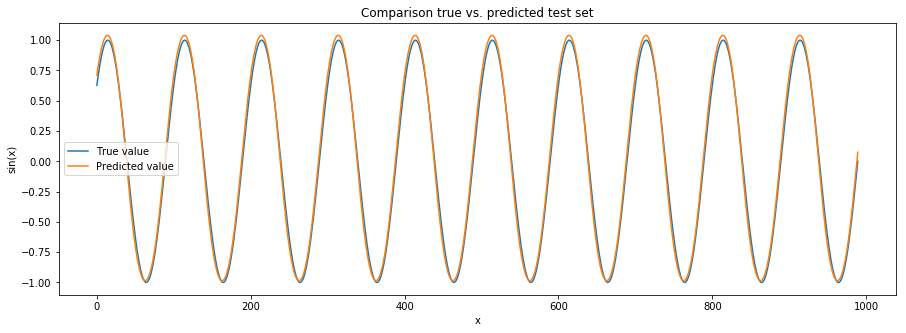

In [27]:
# Predict on test data.
pred_test = model2.predict(test_X)

# Apply inverse transformation to get back true values.
test_y_actual = scaler.inverse_transform(test_Y.values.reshape(test_Y.shape[0], 1))

print("MSE for predicted test set: %2f" % mean_squared_error(test_y_actual, pred_test))

plt.figure(figsize = (15, 5))
plt.plot(test_y_actual, label="True value")
plt.plot(pred_test, label="Predicted value")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("Comparison true vs. predicted test set")
plt.legend()
plt.show()

### Next steps and things to explore

* Should clean up first before doing anything else! ;)


## References and links

* Example 1 source code adapted from here: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Another great post: https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f
* Example 2 code adapted from the above: https://github.com/kmsravindra/ML-AI-experiments/tree/master/AI/LSTM-time_series
* Good paper comparing different time series modeling techniques, including LSTM: https://arxiv.org/pdf/1705.09137.pdf
* Another excellent paper: https://arxiv.org/pdf/1705.05690.pdf
* Brilliant LSTM course by Nando de Freitas: https://www.youtube.com/watch?v=56TYLaQN4N8
